In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.style.use('seaborn-white')
#### OUTPUT #####
fig_path = '/nas2/users/hermuba/fig'

# Reading edgelist from file

In [2]:
# read all network edgelist from file
combined_edge = pd.read_csv('~/nas2/integrate_net/rf_greater_than_01.csv', index_col = 0)

In [3]:
combined_edge.shape

(462461, 8)

In [4]:
combined_edge.head()

,source,target,domain,refseq,eskape,gosim,string,total_score
0,3005,120,104.0,243.0,254.0,NaN,44.0,0.101921
1,3005,343,-1.0,270.0,297.0,NaN,33.0,0.142990
2,3005,2747,239.0,298.0,297.0,0.015,97.0,0.119688
3,3005,1483,220.0,258.0,285.0,0.052,55.0,0.114949
4,3005,3005,-1.0,-1.0,-1.0,NaN,189.0,0.157415


In [5]:
import os
base_path = '/home/hermuba/nas2/resist_subnet/'
annotation_df = os.path.join(base_path, 'gold_anno.csv')
gold_anno = pd.read_csv(annotation_df)
gold_anno.set_index('gene_id', inplace = True)

In [6]:

combined = nx.from_pandas_edgelist(combined_edge, target = 'target', source = 'source',  edge_attr = ['eskape', 'string', 'gosim', 'domain', 'refseq', 'total_score'])

In [7]:
# generate graph for each network
def get_subnet(net):
    edges = combined_edge.loc[combined_edge[net]!= -1]
    return nx.from_pandas_edgelist(edges, target = 'target', source = 'source', edge_attr = [net])

In [8]:
refseq = get_subnet('refseq')
domain = get_subnet('domain')

eskape = get_subnet('eskape')
string = get_subnet('string')


In [9]:
# unique contribution
nets = ['eskape', 'string', 'domain', 'refseq']
def unique_contribution(net):
    other_nets = nets.copy()
    other_nets.remove(net)
    
    only = combined_edge.loc[(combined_edge[net]!= -1) & (combined_edge[other_nets].sum(axis = 1)==-3)]
    return only.shape[0]

In [10]:
for net in nets:
    print(net, unique_contribution(net))

eskape 141121
string 463
domain 9872
refseq 8250


# Calculate network statistics

In [11]:
# calculate how many nodes, annotation in each network
# network stats comparing them
core_genes = gold_anno.loc[gold_anno['core'] == True]
def net_stat(G):
    # core
    number_of_core = len(set(G.nodes()).intersection(gold_anno.loc[gold_anno['core'] == True].index))
    # accessory
    number_of_acc = G.number_of_nodes() - number_of_core
    # hypothetical
    number_of_hypo = len(set(G.nodes()).intersection(gold_anno.loc[gold_anno['hypo_nr'] == True].index))
    # mobile
    number_of_mobile = len(set(G.nodes()).intersection(gold_anno.loc[gold_anno['is_aclame'] == True].index))
    # CARD genes
    number_of_card = len(set(G.nodes()).intersection(gold_anno.loc[gold_anno['is_card'] == True].index))
    # COG annotation
    number_of_cog = len(set(G.nodes()).intersection(gold_anno.loc[gold_anno['cog_ID'].notna()].index))
    return([G.number_of_nodes(), 
            G.number_of_edges(), 
            nx.algorithms.components.number_connected_components(G),
           number_of_core,
           number_of_acc,
           number_of_hypo,
           number_of_mobile,
           number_of_card,
           number_of_cog])

# run
df = pd.DataFrame(columns = ['No. nodes', 'No. edges', 'No. components', 'No. core', 'No. accessory', 'No. hypothetical','No. Aclame', 'No. CARD', 'No. COG'], index = ['RefseqNet', 'EskapeNet', 'StringNet','DomainNet', 'pangenomeNet'])
i = 0
for net in [refseq, eskape, string, domain, combined]:
    
    df.iloc[i] = net_stat(net)
    i+=1

# precentage
n_core = gold_anno['core'].value_counts()[True]
n_acc = gold_anno['core'].value_counts()[False]
n_hypo = gold_anno['hypo_nr'].sum()

df['perc_core'] = df['No. core']/n_core
df['perc_acc'] = df['No. accessory']/n_acc
df['perc_hypo'] = df['No. hypothetical']/n_hypo
df.to_csv(os.path.join(fig_path,'netstat.csv'))

In [12]:
# plot powerlaw for just pan-genome net
from network_analysis.net_arch import *

def plot_powerlaw(net, ax, color = 'royalblue'):
    ''' plot powerlaw plot'''

    logx, logy, line, slope, r_value, p_value = power_law(net)
    #plt.figure(figsize = (3.2,2.3))
    ax.plot(logx, logy, '.', color = color)
    ax.plot(logx, line, color = 'dimgrey' )
    ax.text(1, 5,'r = '+ '{:f}'.format(r_value))
    ax.set_title('Powerlaw distribution')
    ax.set_xlabel('Degree')
    ax.set_ylabel('Frequency')
    ax.set_xticks(list(range(4)))
    ax.set_xticklabels(['$10^{}$'.format(i) for i in range(4)]) #
    ax.set_yticks(list(range(0,8, 2)))
    ax.set_yticklabels(['$10^{}$'.format(i) for i in range(0,8,2)])
    #plt.savefig('/home/hermuba/data0118/fig/fig_5_1_pangenome_powerlaw.svg', format = 'svg', dpi = 300, pad_inches = 1, bbox_inches='tight')
    

most connected node degree  1177
most connected node degree  1239
most connected node degree  371
most connected node degree  807
most connected node degree  1264


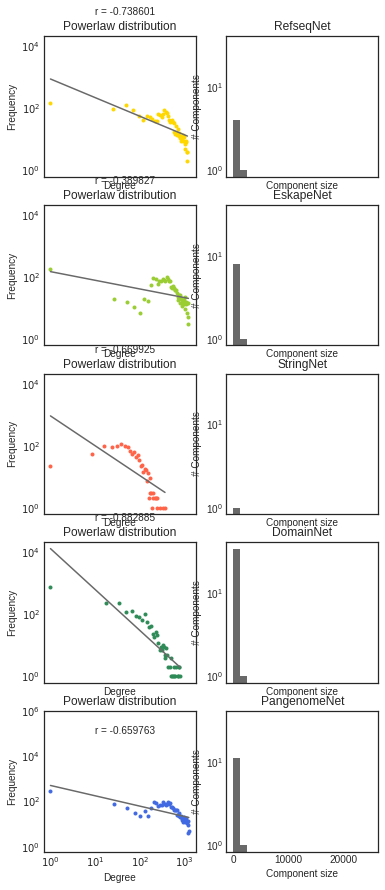

In [13]:
# plot powerlaw and Number of components
fig, axes = plt.subplots(nrows = 5, ncols = 2, sharex = 'col', sharey = 'col', figsize = (6, 15))

row = 0
names = ['RefseqNet', 'EskapeNet', 'StringNet','DomainNet', 'PangenomeNet']
colors = ['gold', 'yellowgreen', 'tomato', 'seagreen', 'royalblue']
for net, c in zip([refseq, eskape, string, domain, combined], colors):
    
    # power law
    plot_powerlaw(net, axes[row, 0], color = c)
    
    
    # subcomponent
    graphs = nx.connected_components(net)
    node_no = [len(g) for g in graphs]

    axes[row,1].hist(node_no, bins = 20, log = True, range = (0,25000), color = 'dimgrey')
    axes[row,1].set_xlabel('Component size')
    axes[row,1].set_ylabel('# Components')
    axes[row,1].set_title(names[row])
    
    
    # next net
    row += 1

    
    
    
plt.savefig(os.path.join(fig_path,'component_size_powerlaw.svg'), format = 'svg', dpi = 300, pad_inches = 1, bbox_inches='tight')
    
    


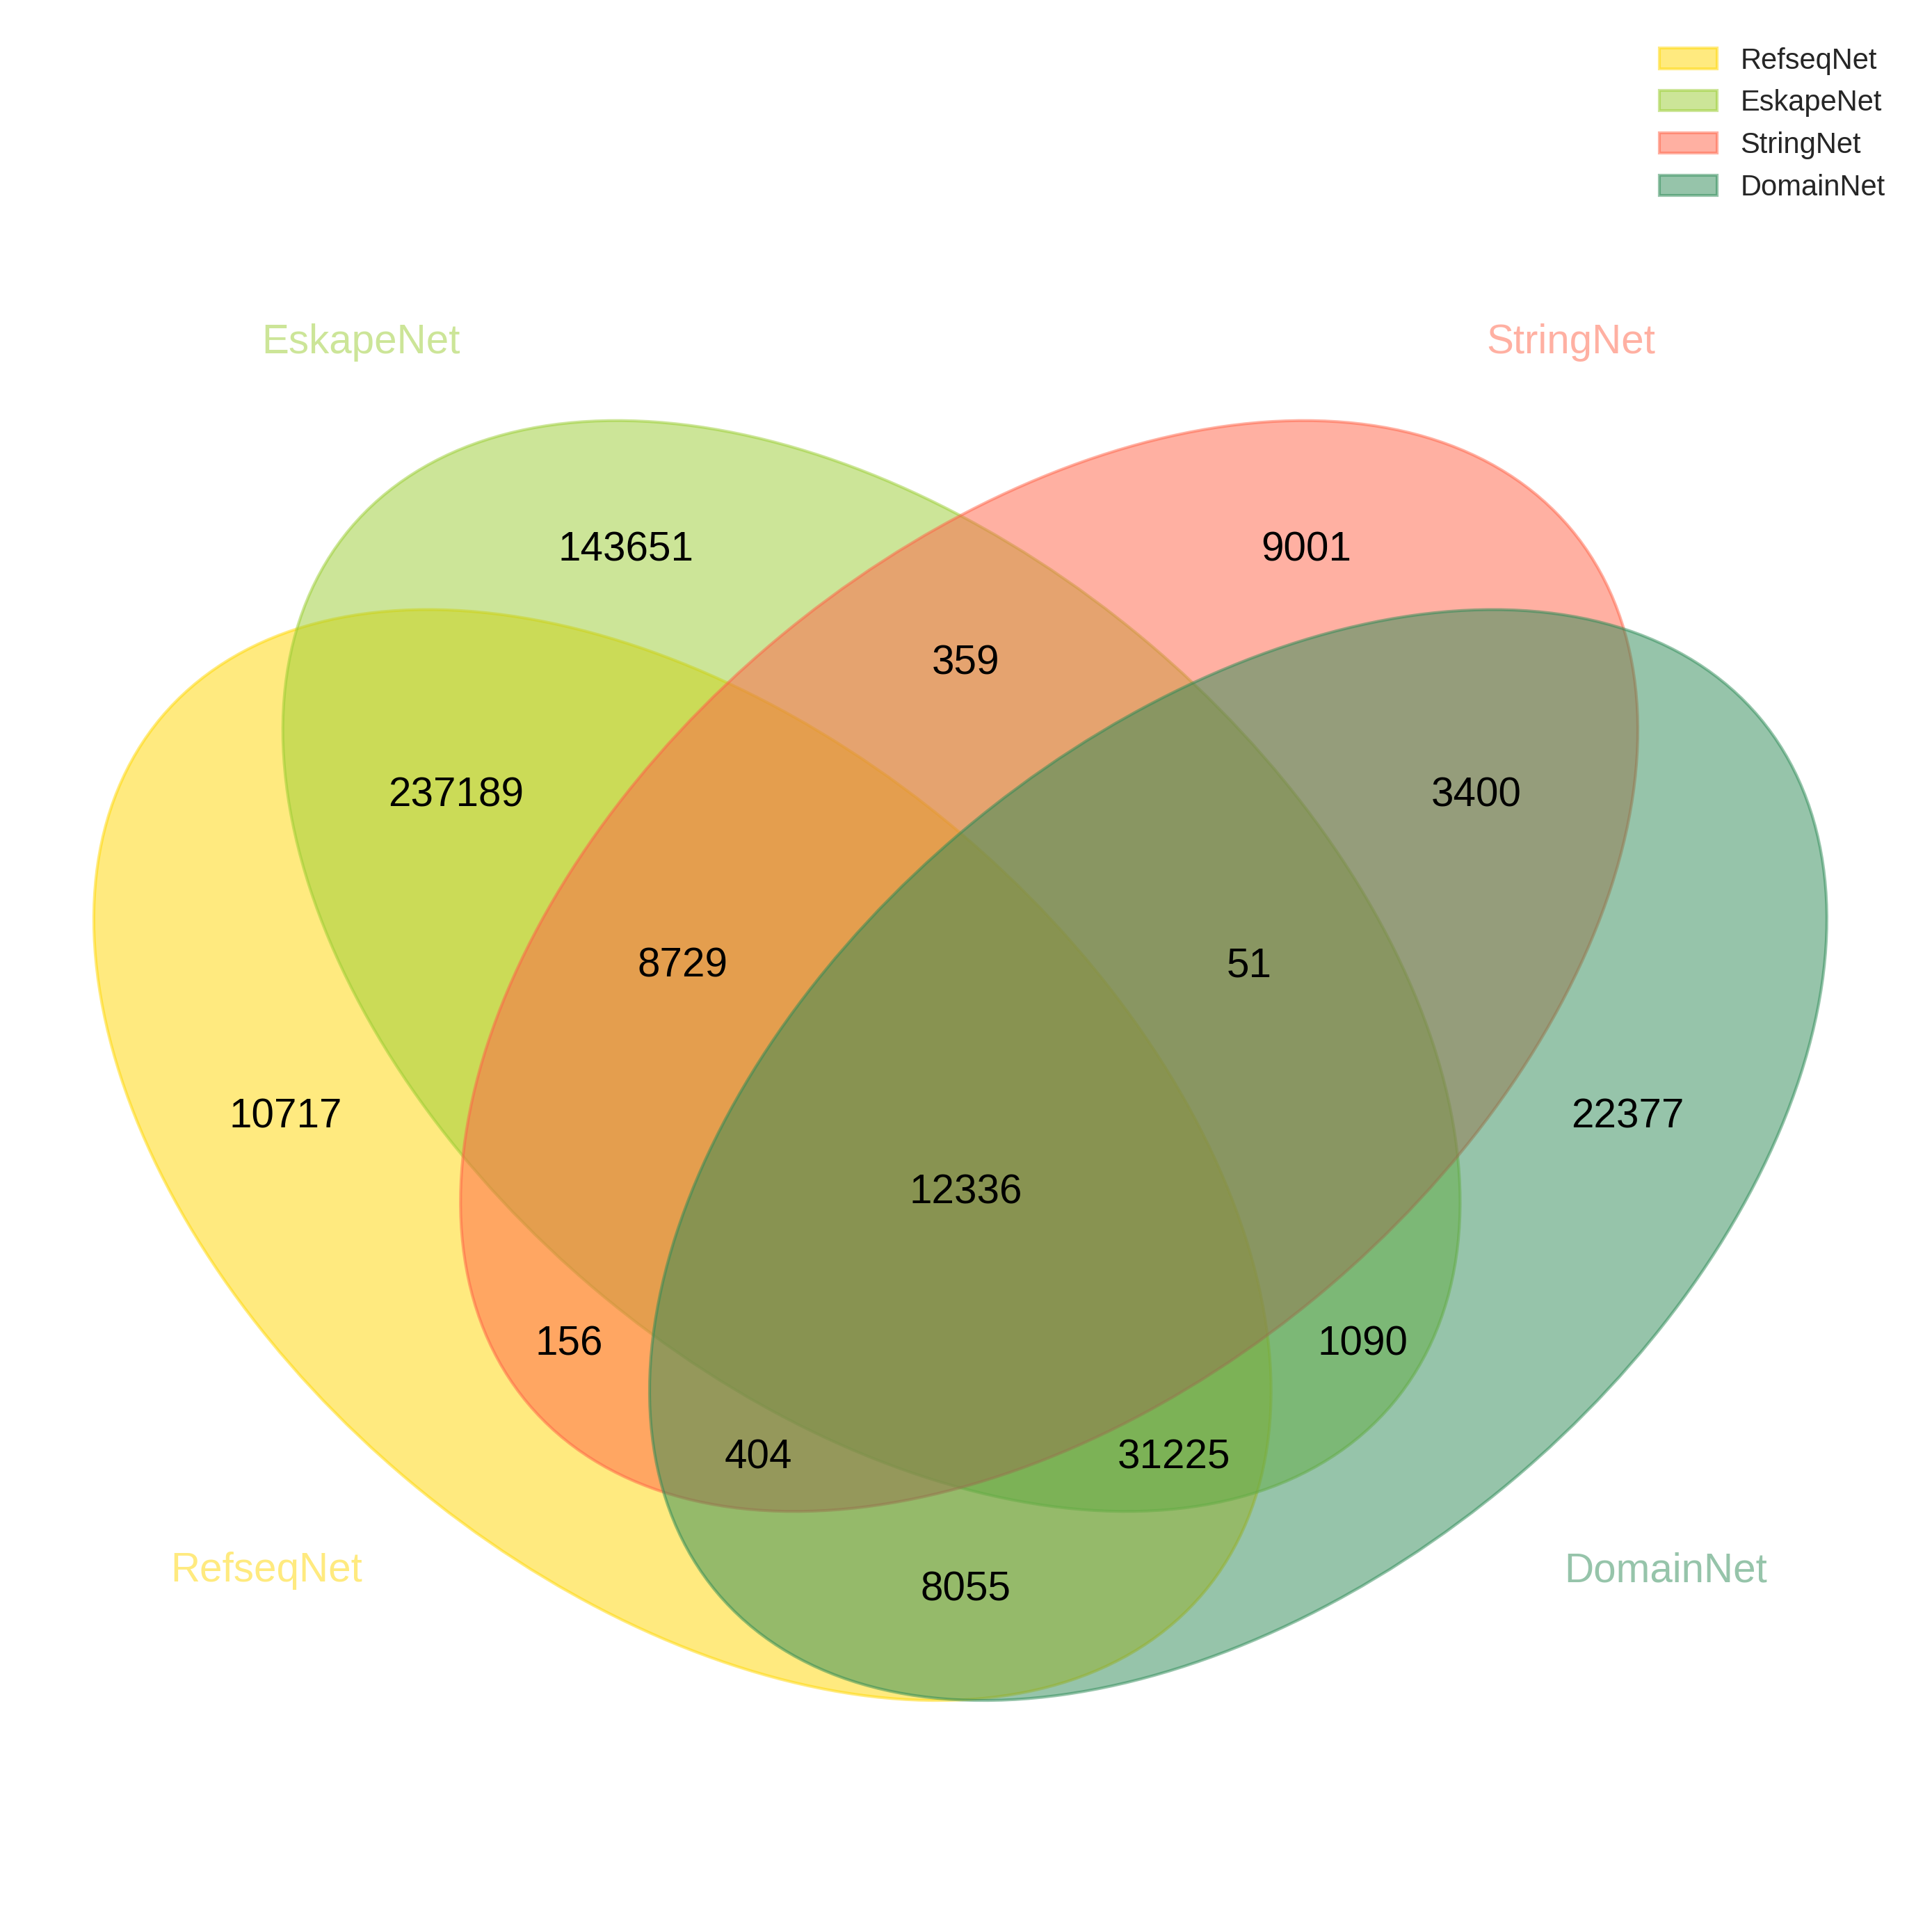

In [14]:
# edge relation

import sys

sys.path.append('/home/hermuba/pyvenn')
import venn

colors = [mpl.colors.to_rgba(c, alpha = 0.5) for c in ['gold', 'yellowgreen', 'tomato', 'seagreen']]

labels = venn.get_labels([refseq.edges(), eskape.edges(), string.edges(), domain.edges()], fill=['number'])
fig, ax = venn.venn4(labels, names=['RefseqNet', 'EskapeNet', 'StringNet', 'DomainNet'], colors = colors, dpi = 300)

plt.savefig(os.path.join(fig_path,'edge_venn.svg'), format = 'svg', dpi = 300, pad_inches = 1, bbox_inches='tight')
fig.show()
#plt.close('all')



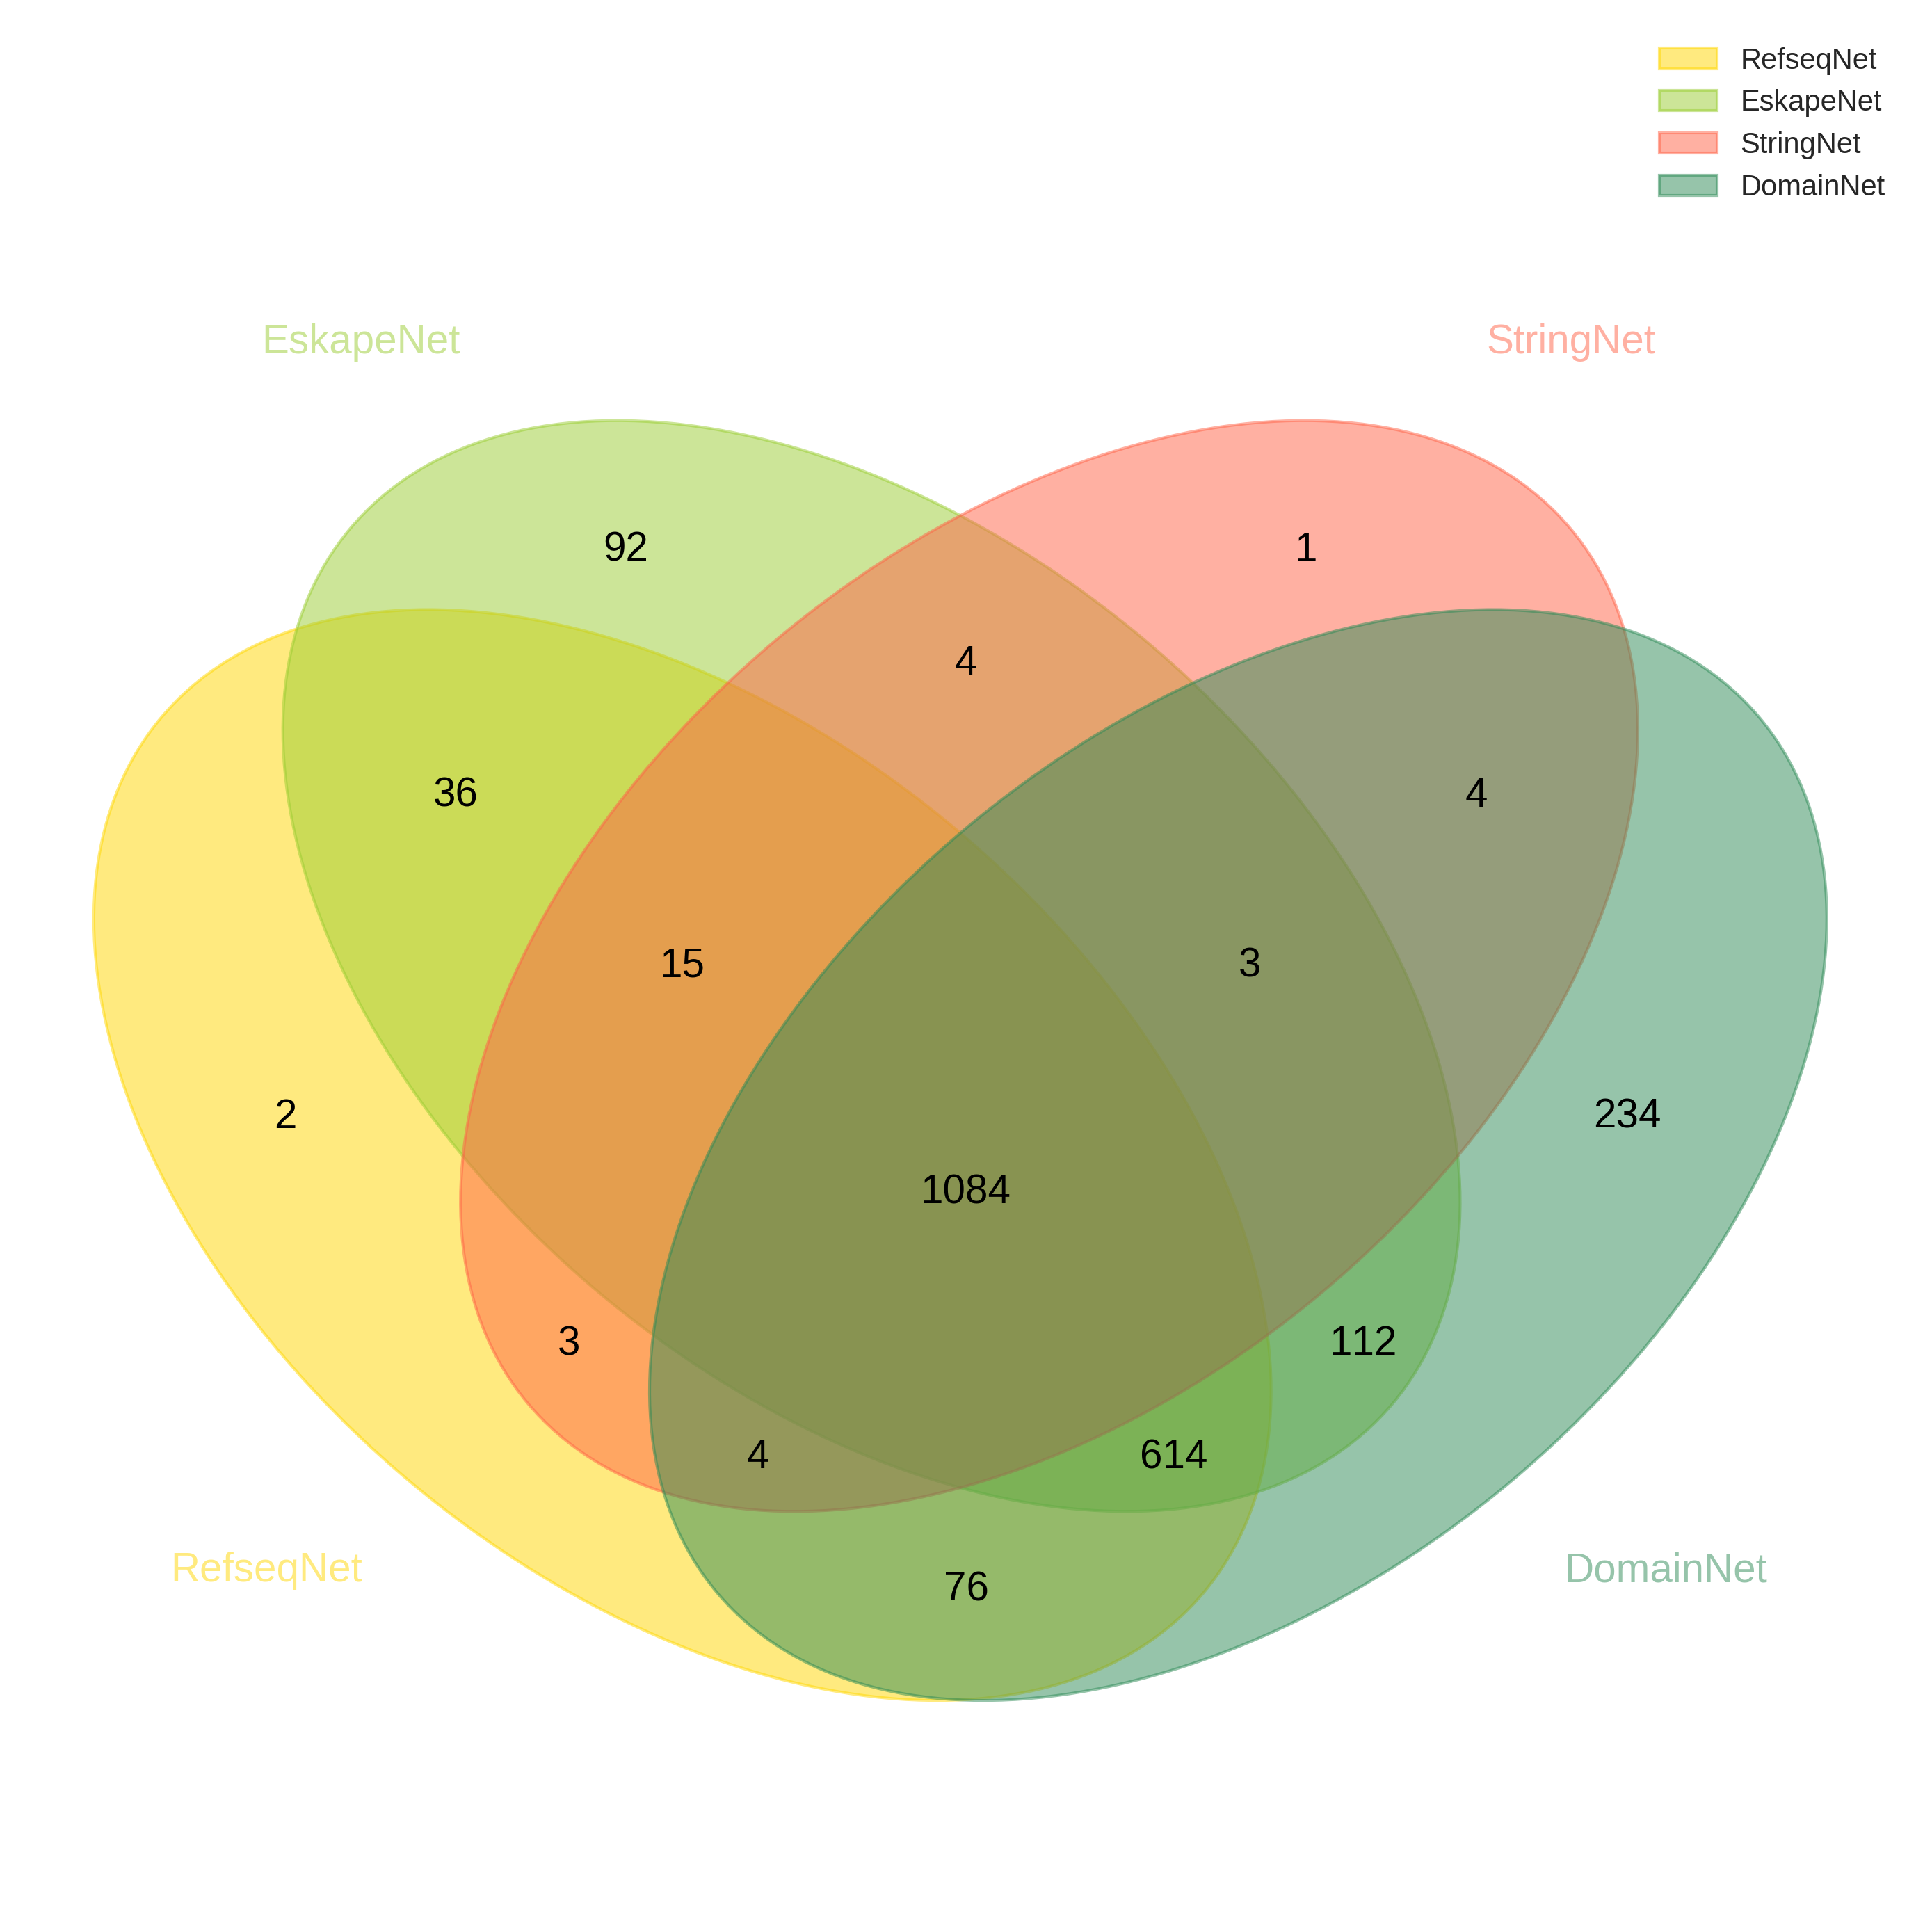

In [15]:
# edge relation
colors = [mpl.colors.to_rgba(c, alpha = 0.5) for c in ['gold', 'yellowgreen', 'tomato', 'seagreen']]

labels = venn.get_labels([refseq.nodes(), eskape.nodes(), string.nodes(), domain.nodes()], fill=['number'])
fig, ax = venn.venn4(labels, names=['RefseqNet', 'EskapeNet', 'StringNet', 'DomainNet'], colors = colors, dpi = 300)

plt.savefig(os.path.join(fig_path,'node_venn.svg'), format = 'svg', dpi = 300, pad_inches = 1, bbox_inches='tight')
fig.show()



In [16]:
# show how many nodes each network contribute
names = ['EskapeNet', 'RefseqNet', 'StringNet', 'DomainNet']
node_contribution = pd.DataFrame(index = combined.nodes(), columns = names)
for net, name in zip([eskape, refseq, string, domain], names):
    node_contribution.loc[list(net.nodes), name] = True
node_contribution.fillna(False, inplace =True)

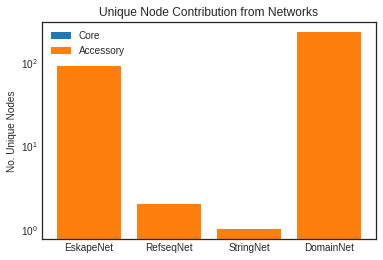

In [17]:
# find net-unique nodes and label them as acc or core
acc = []
core = []
for name in names:
    unique_genes = node_contribution.loc[(node_contribution.sum(axis = 1) == 1) & (node_contribution[name])].index
    no_core = gold_anno.loc[list(set(unique_genes).intersection(set(gold_anno.index))), 'core'].sum()
    no_acc = len(unique_genes) - no_core

    acc.append(no_acc)
    core.append(no_core)

# plot it
ind = np.arange(len(acc))

p1 = plt.bar(ind, core)
p2 = plt.bar(ind, acc,
             bottom=core)

plt.ylabel('No. Unique Nodes')
plt.title('Unique Node Contribution from Networks')
plt.xticks(ind, names)
#plt.yticks(np.arange(0, 81, 10))
plt.legend((p1[0], p2[0]), ('Core', 'Accessory'))
plt.yscale('log')

plt.savefig(os.path.join(fig_path,'unique_node.svg'), format = 'svg', dpi = 300, pad_inches = 1, bbox_inches='tight')
plt.show()
    

In [18]:
# calculate centrality of each nodes
dc = nx.algorithms.centrality.degree_centrality(combined)
for k in dc.keys():
    gold_anno.loc[k ,'degree_centrality']  = dc[k]

In [19]:
# split cog into 0101

split_cog = gold_anno.loc[gold_anno['cog_category'].notnull()]['cog_category'].apply(list)
cog_df = pd.DataFrame(columns = ['J','A','K','L','B','D','Y','V','T','M','N','Z','W','U','O','C','G','E','F','H','I','P','Q','R','S','no COG'], index = gold_anno.index)

# make into 0101 table
for i in split_cog.index:
    cog_lists = split_cog[i]
    for each_category in cog_lists:
        cog_df.loc[i, each_category] = True

# find those without COG
cog_df.loc[gold_anno.loc[gold_anno['cog_category'].isnull()].index, 'no COG'] = True
cog_df.fillna(False, inplace = True)

In [20]:
def how_many_asterstick(pvalue):
    if pvalue < 0.05 and pvalue > 0.001:
        return '*'
    elif pvalue < 0.001:
        return '***'
    else:
        return ''

===Core vs acc====
pval=2.211945084355869e-85
===Hypo vs known====
pval=7.813710772897159e-232
===AMR vs non-AMR====
pval=0.0003647929488668211
most connected node degree  1264


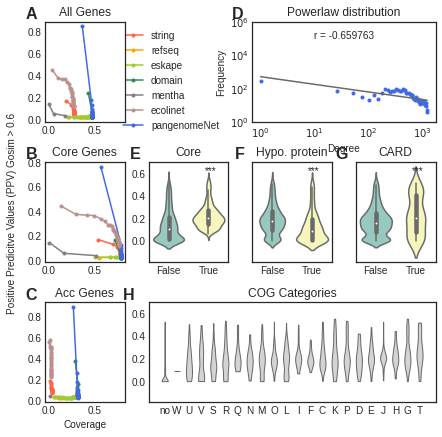

In [21]:
# pangenome property
import seaborn as sns
from scipy.stats import ks_2samp
fig, ax = plt.subplots(3,4, sharey = True, figsize = (7, 7))
ax1 = plt.subplot2grid((3, 4), (1, 1), colspan = 1) # core-acc
ax2 = plt.subplot2grid((3, 4), (1, 2), colspan = 1, sharey = ax1)
ax3 = plt.subplot2grid((3, 4), (1, 3), colspan = 1, sharey = ax1)

ax4 = plt.subplot2grid((3, 4), (2, 1), colspan=3, sharey = ax1) # cog

ax5 = plt.subplot2grid((3, 4), (0, 2), colspan=2) # powerlaw
ax_legend = plt.subplot2grid((3, 4), (0, 1), colspan=1, frameon = False)
ax_legend.set_xticklabels('')
ax_legend.set_yticklabels('')

ax6 = plt.subplot2grid((3, 4), (0, 0), colspan = 1)  # ppv_coverage
ax7 = plt.subplot2grid((3, 4), (1, 0), colspan = 1, sharex = ax6)
ax8 = plt.subplot2grid((3, 4), (2, 0), colspan = 1, sharex = ax6)


axes = [ax1, ax2, ax3, ax4]
_ = [ax.text(-0.1, 1.15, lbl, transform=ax.transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right') for lbl, ax in zip(list('EFG'), axes[:-1])]
_ = [ax.text(-0.05, 1.15, lbl, transform=ax.transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right') for lbl, ax in zip(list('HD'), [ax4, ax5])]

#### Core vs accessory genes ########
#gold_anno.boxplot(by = 'core', column = 'degree_centrality', ax = ax1)
sns.violinplot(data = gold_anno, x = 'core', y = 'degree_centrality', ax = ax1, palette="Set3")
#plt.sca(ax1)
ax1.set_title('Core')
ax1.set_ylabel('Degree Centrality')

print('===Core vs acc====')
ks, pval = ks_2samp(gold_anno.loc[gold_anno['core'], 'degree_centrality'], gold_anno.loc[~gold_anno['core'], 'degree_centrality'])
print(f'pval={pval}')
ax1.text(0.9,0.6, how_many_asterstick(pval))
#ax1.set_ylim(0,1)

#### Hypothetical ########
gold_anno['hypo_nr'] = gold_anno['hypo_nr'].fillna(False)
sns.violinplot(data = gold_anno, x = 'hypo_nr', y = 'degree_centrality', ax = ax2, palette="Set3")
ax2.set_title('Hypo. protein')
plt.setp(ax2.get_yticklabels(), visible=False)
ax2.set_ylabel('')

print('===Hypo vs known====')
ks, pval = ks_2samp(gold_anno.loc[~gold_anno['hypo_nr'], 'degree_centrality'], gold_anno.loc[gold_anno['hypo_nr'], 'degree_centrality'])
ax2.text(0.9,0.6, how_many_asterstick(pval))
print(f'pval={pval}')






############# COG category #############
seq_of_cen = []
cog_categories=list(cog_df.columns)
cog_categories.remove('A') # don't know where this comes from
for cog in cog_categories:
    subset_df =gold_anno.loc[cog_df.loc[cog_df[cog]].index,'degree_centrality'].fillna(0)
    
    if len(subset_df)==0:
        pass
    else:
        seq_of_cen.append([subset_df.values, subset_df.median(), cog]) # values, median, cog

sorted_by_medium = sorted(seq_of_cen, key=lambda tup: tup[1])
values = [s[0] for s in sorted_by_medium]
labels = [s[2] for s in sorted_by_medium]



parts= ax4.violinplot(values, showmeans=False, showmedians=False,showextrema=False)
for pc in parts['bodies']: # custom style
    pc.set_facecolor('lightgrey')
    pc.set_edgecolor('dimgrey')
    pc.set_alpha(1)
ax4.set_xticks(list(range(1,len(labels)+1)))

labels = ['no' if l == 'no COG' else l for l in labels]
ax4.set_xticklabels(labels)
ax4.set_title('COG Categories')
ax4.set_ylabel('Degree Centrality')



############# CARD category #############

sns.violinplot(data = gold_anno, x = 'is_card', y = 'degree_centrality', ax = ax3, palette="Set3")

ax3.set_title('CARD')
plt.setp(ax3.get_yticklabels(), visible=False)
ax3.set_ylabel('')

print('===AMR vs non-AMR====')
ks, pval = ks_2samp(gold_anno.loc[gold_anno['is_card'], 'degree_centrality'], gold_anno.loc[~gold_anno['is_card'], 'degree_centrality'])
print(f'pval={pval}')
ax3.text(0.9,0.6, how_many_asterstick(pval))

_ = [axes[i].set_xlabel("") for i in range(4)]
#_ = [axes[i].set_ylabel('degree centrality') for i in range(4)]
plot_powerlaw(combined, ax5)

################## PPV- coverage ###########################
import pandas as pd
# make into pipeline

netname = ['string', 'refseq', 'eskape', 'domain', 'totalrf', 'mentha', 'ecolinet']

gene_set = ['all', 'core', 'acc']
gene_set_name = ['All', 'Core', 'Accessory']
color = ['tomato', 'orange', 'yellowgreen', 'seagreen', 'royalblue', 'grey', 'rosybrown']


result_dict = {}

for name in netname:
    result_dict[name] = {}
    tradeoff = pd.read_csv('/home/hermuba/nas2/resist_subnet/preformance/{}.ppv_cov.csv'.format(name), index_col = 0)
    for gset, gn in zip(gene_set, gene_set_name):
        #tradeoff = try_diff_lls_thres(n, gold, score_colname = s, gene_set = gset)
        if gset == 'all':
            result_dict[name][gset] = tradeoff[['ppv', 'cov']]
        else:
            df = tradeoff[['{}_ppv'.format(gset), '{}_cov'.format(gset)]]
            df.columns = ['ppv', 'cov']
            result_dict[name][gset] = df
        #tradeoff.to_csv('~/data0118/PPV_coverage/{}_rm_plasmid_{}'.format(name, gset))
i = 0
for gset, ax, lbl in zip(gene_set, [ax6, ax7, ax8], list('ABC')):
    # import all PPV-coverage tradeoff
    for name, c in zip(netname, color):
        tradeoff = result_dict[name][gset]
        tradeoff = tradeoff.loc[(tradeoff['cov']>0) & (tradeoff['ppv']>0)] # last bin has only 1 gene left
        ax.plot(tradeoff['cov'], tradeoff['ppv'], '.-',  label = name, color = c)
        
    if i == 2:
        ax.set_xlabel('Coverage')
    
    ax.set_title('{} Genes'.format(gset.capitalize()))
    ax.text(-0.1, 1.15, lbl, transform=ax.transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')
    i += 1

    
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
by_label['pangenomeNet']=by_label['totalrf']
del by_label['totalrf']
ax_legend.legend(by_label.values(), by_label.keys())


fig.text(0.05, 0.5, 'Positive Predicitve Values (PPV) Gosim > 0.6', va='center', rotation='vertical')
fig.subplots_adjust(wspace=0.3,hspace = 0.4)

#fig.tight_layout()
plt.suptitle("")
#plt.tight_layout()
plt.savefig(os.path.join(fig_path,'centrality_ppv_powerlaw.svg'), format = 'svg', dpi = 300, pad_inches = 1, bbox_inches='tight')

In [22]:
essential=list('ECFHKMLGIJ')

essential_genes  = cog_df.loc[cog_df[essential].any(axis = 1)].index
nonessential_genes = set(cog_df.index)-set(essential_genes)

esen_deg=gold_anno.loc[essential_genes,'degree_centrality'].fillna(0)
non_esen_deg=gold_anno.loc[nonessential_genes,'degree_centrality'].fillna(0)

In [23]:
print('===Essential vs non_essential ====')
ks, pval = ks_2samp(esen_deg, non_esen_deg)
print(f'pval={pval}')

===Essential vs non_essential ====
pval=1.496456938447475e-127


In [24]:
sns.ecdfplot(esen_deg, non_esendeg)

AttributeError: module 'seaborn' has no attribute 'ecdfplot'

In [ ]:
by_label

In [ ]:
fig, ax = plt.subplots(2,2, figsize = (6,6), sharey = True)
ax = ax.flatten()
sns.violinplot(data = gold_anno, x = 'is_aclame', y = 'degree_centrality', ax = ax[0], palette="Set3")
ax[0].set_title('Mobile Elements(Aclame)')

sns.violinplot(data = gold_anno, x = 'is_drug_target', y = 'degree_centrality', ax = ax[1], palette="Set3")
ax[1].set_title('Drug Target')

# with pathway annotation
gold_anno['is_path'] = gold_anno['pathway'].notnull()
sns.violinplot(data = gold_anno, x = 'is_path', y = 'degree_centrality', ax = ax[2], palette="Set3")
ax[2].set_title('Pathway annotation')

# with GO annotation

gold_anno['is_go'] = gold_anno['GO'].notnull()
sns.violinplot(data = gold_anno, x = 'is_go', y = 'degree_centrality', ax = ax[3], palette="Set3")

ax[3].set_title('GO annotation')
_ = [ax[i].set_xlabel("") for i in range(4)]
_ = [ax[i].set_ylabel("") for i in [1,3]]

fig.tight_layout()
plt.suptitle("")
plt.savefig(os.path.join(fig_path,'sup_centrality.svg'), format = 'svg', dpi = 300, pad_inches = 1, bbox_inches='tight')